## Regressão Logistica

In [2]:
import keras 
import pandas as pd
import tensorflow as tf 
import seaborn as sea
import matplotlib.pyplot as plt
from pyprind.progbar import ProgBar

In [3]:
class modelo(tf.Module):
    def __init__(self, name=None, n_features=1, seed=42):
        super().__init__(name)

        # Inicializando peso aleatóriamente
        tf.random.set_seed(seed=seed)


        rnd = tf.random.normal(shape=[1, n_features], dtype=tf.float32)
    
        ## Adicionando uma coluna de 1 = interceptor    
        params = tf.concat([
            tf.ones_like(rnd[:, 0:1]),
            rnd
        ], axis=1)
        
        self.params = tf.Variable(initial_value=params, name='params', dtype=tf.float32)

        
    def __call__(self, X):
        X_ = tf.concat([tf.ones_like(X[:, 0:1]), X], axis=1)
        return tf.matmul(X_, self.params, transpose_b=True)

    def summary(self):
        print(f'Params: {self.params.numpy().tolist()}')

### Classificação

1. **Classificação Binária :** Somente duas classes
2. **Classificação Multiclasse :** Mais de duas classes 

In [4]:
iris = pd.read_csv('datasets/Iris.csv')
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
iris.drop(columns=['Id'], inplace=True)

### Classificação Binária

In [6]:
iris['class'] = iris['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

In [7]:
subset = iris.loc[iris['class'].isin([0, 1])].iloc[:,[0, 1, 4, 5]]
subset.head()

,SepalLengthCm,SepalWidthCm,Species,class
0,5.1,3.5,Iris-setosa,0
1,4.9,3.0,Iris-setosa,0
2,4.7,3.2,Iris-setosa,0
3,4.6,3.1,Iris-setosa,0
4,5.0,3.6,Iris-setosa,0


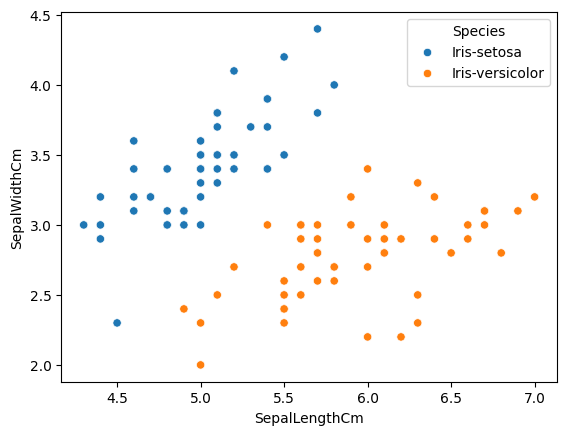

In [8]:
sea.scatterplot(x='SepalLengthCm', y='SepalWidthCm', hue='Species', data=subset)
plt.show()

Função Sigmoid

$$\sigma(z) = \frac{1}{1+exp(-z)}$$

In [9]:
def sigmoid(z):
    return 1 / (1 + tf.exp(-z))

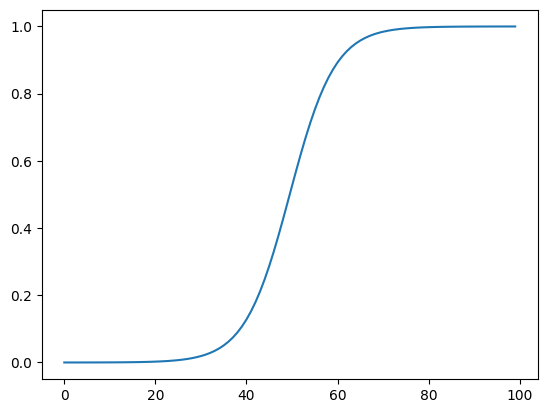

In [10]:
plt.plot(sigmoid(tf.linspace(-10, 10, 100)))
plt.show()

`gradiente`

In [11]:
def gradiente(x, y, name_model='modelo', epochs=1000, lr=0.01):
    model = modelo(name=name_model, n_features=x.shape[1])
    N = x.shape[0]
    
    x  = tf.Variable(x, dtype=tf.float32)
    #
    x_ = tf.concat([tf.ones_like(x[:, 0:1]), x], axis=1)
    y  = tf.Variable(y, dtype=tf.float32)

    progbar = ProgBar(epochs, title='Treinando modelo', stream=1)
    for epoch in range(epochs):
        pred = tf.matmul(x_, model.params, transpose_b=True)

        pred = sigmoid(pred)

        grad = lr * (1/N) * tf.matmul(x_, y - pred, transpose_a=True)

        grad = tf.reshape(grad, [1, -1])

        model.params.assign_add(grad)

        # Printa em epocas
        progbar.update(1, item_id=f'Epochs : {epoch}')
    return model

In [12]:
X =  iris[iris['class'].isin([0, 1])][['SepalLengthCm', 'SepalWidthCm']].values.astype('float32')
y =  iris[iris['class'].isin([0, 1])]['class'].values.reshape(-1, 1).astype('float32')

In [13]:
X = (X - X.mean(axis=0))/X.std(axis=0)

In [14]:
model_result = gradiente(x=X, y=y, name_model='logistic', epochs=1000, lr=0.01)

Treinando modelo
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epochs : 999
Total time elapsed: 00:00:01


In [15]:
def plot_fronteira_decisao(model, x, y):
    import  numpy as np
    # Garante que x e y sejam arrays numpy
    x = x
    y = y.ravel()

    # Gera uma grade de pontos
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Cria o grid de entrada (com o bias = 1)
    grid = np.c_[np.ones((xx.ravel().shape[0], 1)),
                 xx.ravel(), yy.ravel()]

    # Calcula a predição
    params = model.params.numpy()  # converte os pesos do modelo para numpy
    pred = tf.sigmoid(tf.matmul(grid, params, transpose_b=True))
    Z = np.where(pred.numpy() >= 0.5, 1, 0)
    Z = Z.reshape(xx.shape)

    # Faz o plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', edgecolors='k')
    plt.title('Fronteira de decisão')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

Treinando modelo
0% [##############################] 100% | ETA: 00:00:00 | Item ID: Epochs : 999
Total time elapsed: 00:00:01


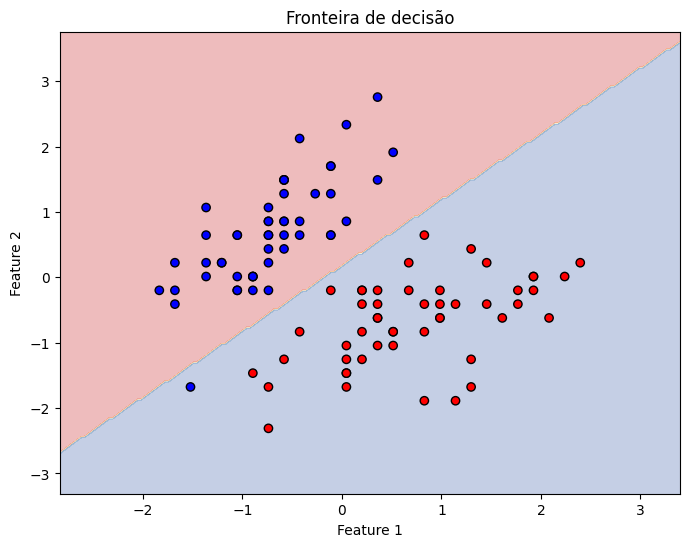

In [16]:
modelo_treinado = gradiente(X, y, epochs=1000, lr=0.01)
plot_fronteira_decisao(modelo_treinado, X, y)

In [17]:
pred = (sigmoid(model_result(X)) >= 0.5).numpy().astype(int)

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y,pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        50
         1.0       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



`Gradiente estocastico`

In [19]:
def gradiente_estocatisco(x, y, name_model='modelo', epochs=1000, lr=0.01):
    model = modelo(name=name_model, n_features=x.shape[1])
    N = x.shape[0]
    
    x  = tf.Variable(x, dtype=tf.float32)
    #
    x_ = tf.concat([tf.ones_like(x[:, 0:1]), x], axis=1)
    y  = tf.Variable(y, dtype=tf.float32)

    index = tf.range(start=0, limit=x.shape[1], dtype=tf.int32, name='indices')

    progbar = ProgBar(epochs, title='Treinando modelo', stream=1)
    for epoch in range(epochs):
        embaralhar = tf.random.shuffle(index)

        for idx in embaralhar:
            xi = x_[idx, :]
            yi = y[idx]

            pred = tf.matmul(xi, model.params, transpose_b=True)

            pred = sigmoid(pred)

            grad = lr * (1/N) * tf.matmul(xi, yi - pred, transpose_a=True)

            grad = tf.reshape(grad, [1, -1])

            model.params.assign_add(grad)

            # Printa em epocas
        progbar.update(1, item_id=f'Epochs : {epoch}')
    return model

In [ ]:
model = gradiente_estocatisco(X, y, name_model='sgd')

In [ ]:
model.summary()

Params: [[0.2951146960258484, 1.6599935293197632, -1.646945595741272]]


In [ ]:
pred = ( sigmoid(model(X)) >= .5).numpy().astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y,pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        50
         1.0       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

